## Foward pass and back propagation

https://github.com/fastai/course22p2/tree/master/nbs
notebook 3 and 4

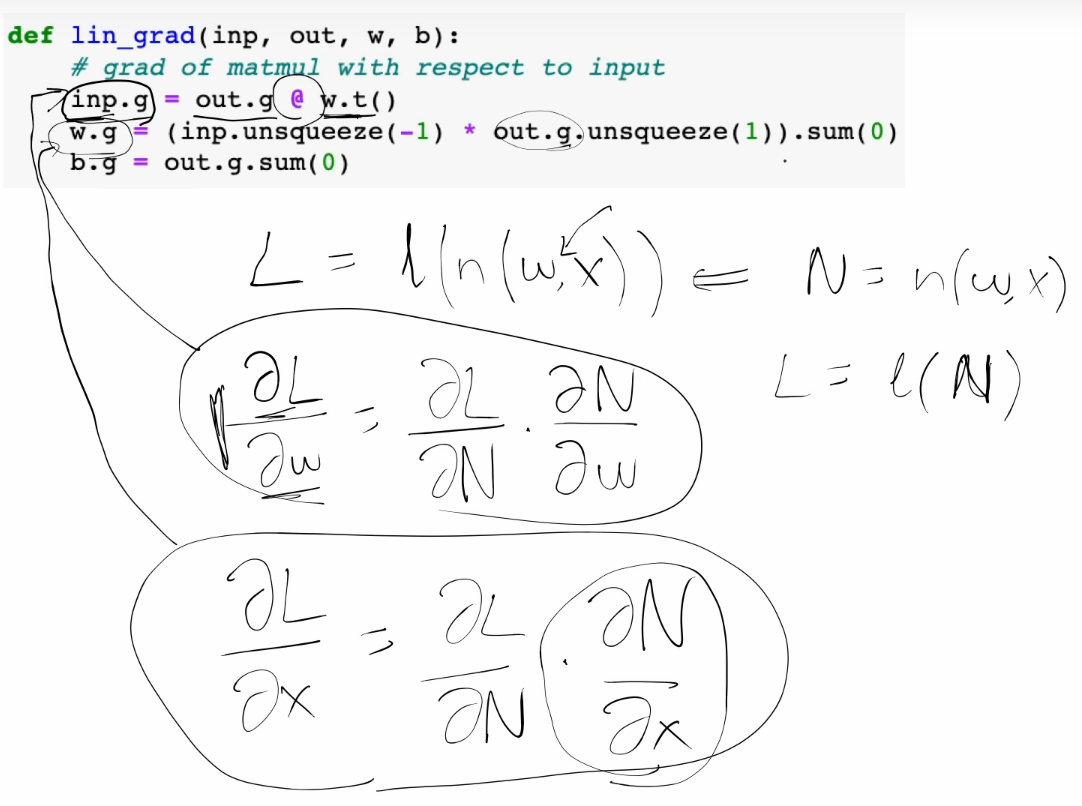




In [92]:
!wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz


--2024-07-15 10:58:44--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz.1’

mnist.pkl.gz.1      100%[===================>]  16.26M  39.8MB/s    in 0.4s    

2024-07-15 10:58:45 (39.8 MB/s) - ‘mnist.pkl.gz.1’ saved [17051982/17051982]



In [93]:

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

path_data = Path('.')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])



In [94]:
n,m =x_train.shape
c = y_train.max()+1
n,m,c
# n: number of samples
# m: number of inputs
# c: number of targets

(50000, 784, tensor(10))

In [95]:
nh = 50
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [96]:
def lin(x,w,b): return x@w +b
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [97]:
def relu(x): return x.clamp_min(0.)
t= relu(t)
t

tensor([[ 0.00, 11.87,  0.00,  ...,  5.48,  2.14, 15.30],
        [ 5.38, 10.21,  0.00,  ...,  0.88,  0.08, 20.23],
        [ 3.31,  0.12,  3.10,  ..., 16.89,  0.00, 24.74],
        ...,
        [ 4.01, 10.35,  0.00,  ...,  0.23,  0.00, 18.28],
        [10.62,  0.00, 10.72,  ...,  0.00,  0.00, 18.23],
        [ 2.84,  0.00,  1.43,  ...,  0.00,  5.75,  2.12]])

In [98]:
def model(xb):
  l1 = lin(xb, w1, b1)
  l2 = relu(l1)
  return lin(l2,w2,b2)

In [99]:
x_valid.shape

torch.Size([10000, 784])

In [100]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

In [101]:
res.shape, y_valid.shape


(torch.Size([10000, 1]), torch.Size([10000]))

In [102]:
res = res[:,0]
(res-y_valid).shape

torch.Size([10000])

In [103]:
y_train,y_valid = y_train.float(),y_valid.float()

preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [104]:
def mse(output, targ): return (output[:,0]-targ).pow(2).mean()

In [105]:
mse(preds, y_train)

tensor(4308.76)

In [106]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

2*x

 Loss= LossFunc(NN(INPUT, WEIGHT) , TARGET)

 We change weight to optimize loss


In [107]:
diff(3*x**2+9, x)


6*x

In [108]:

def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    # import pdb ; pdb.set_trace()
    # Option 1
    #i, o = inp.unsqueeze(-1)  ,  out.g.unsqueeze(1)
    #w.g = (i * o).sum(0)
    # option 2
    w.g = inp.T @ out.g
    b.g = out.g.sum(0)

## PDB : Python debugging

In [109]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out[:,0]-targ
    loss = diff.pow(2).mean()

    # backward pass:
    out.g = 2.*diff[:,None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

In [110]:
forward_and_backward(x_train, y_train)

In [111]:
x_train.g

tensor([[    -0.00,     -0.01,      0.00,  ...,     -0.00,      0.00,      0.00],
        [    -0.03,     -0.03,      0.01,  ...,     -0.04,     -0.01,     -0.01],
        [     0.00,      0.00,     -0.00,  ...,      0.00,     -0.00,      0.00],
        ...,
        [    -0.00,     -0.02,      0.01,  ...,     -0.00,     -0.00,      0.00],
        [    -0.02,     -0.01,      0.01,  ...,     -0.01,      0.01,     -0.00],
        [    -0.00,     -0.00,      0.00,  ...,     -0.00,     -0.00,     -0.00]])

In [112]:
def get_grad(x): return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

In [113]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [114]:
def forward(inp, targ):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targ)

In [115]:
loss = forward(xt2, y_train)
loss.backward()

In [116]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)


In [117]:
class A:
  def __call__(self): print("hi")
a = A()
a()

hi


In [118]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out

    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

Each layer, should store the intermediate results so that when it comes to backward, it can use it.

In [119]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b

    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out

    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)


In [120]:
class Mse():
    def __call__(self, inp, targ):
        self.inp,self.targ = inp,targ
        self.out = mse(inp, targ)
        return self.out

    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [121]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()

    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)

    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [122]:
model = Model(w1, b1, w2, b2)
loss = model(x_train, y_train)
model.backward()

test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

## REFACTOR USING PYTHON MODULE

In [123]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [124]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g


class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [125]:
model = Model(w1, b1, w2, b2)
loss = model(x_train, y_train)
model.backward()


test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

## REFACTOR USING PYTORCH MODULE, AUTOGRAD

No need to implmenet backward since grads are automatically calucluated if we use `nn` functions

In [126]:
from torch import nn
import torch.nn.functional as F

In [127]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in,n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    def forward(self, inp): return inp@self.w + self.b

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh,n_out)]

    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ[:,None])

model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

l0 = model.layers[0]
l0.b.grad

tensor([-19.60,  -2.40,  -0.12,   1.99,  12.78, -15.32, -18.45,   0.35,   3.75,  14.67,  10.81,  12.20,  -2.95, -28.33,
          0.76,  69.15, -21.86,  49.78,  -7.08,   1.45,  25.20,  11.27, -18.15, -13.13, -17.69, -10.42,  -0.13, -18.89,
        -34.81,  -0.84,  40.89,   4.45,  62.35,  31.70,  55.15,  45.13,   3.25,  12.75,  12.45,  -1.41,   4.55,  -6.02,
        -62.51,  -1.89,  -1.41,   7.00,   0.49,  18.72,  -4.84,  -6.52])

## minibatch training

In [128]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('.')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

n,m = x_train.shape
c = y_train.max()+1
nh = 50

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x
model = Model(m, nh, 10)

pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [129]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()
log_softmax(pred)


tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [130]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [131]:
y_train[:3]


tensor([5, 0, 4])

In [132]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]


(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

### Negative log lokelihood

In [133]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [134]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)


### nll_loss .  F.log_softmax    = cross_entropy

In [135]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)


## Training loop

Basically the training loop repeats over the following steps:

get the output of the model on a batch of inputs
compare the output to the labels we have and compute a loss
calculate the gradients of the loss with respect to every parameter of the model
update said parameters with those gradients to make them a little bit better


In [136]:
loss_func = F.cross_entropy
bs=50
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

yb = y_train[0:bs]
yb


tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

In [137]:
loss_func(preds, yb)


tensor(2.30, grad_fn=<NllLossBackward0>)

In [138]:
preds.argmax(dim=1)


tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5])

In [139]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()
accuracy(preds, yb)


tensor(0.08)

In [140]:
lr = 0.5
epochs = 3
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [141]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


## Using parameters and optim


In [142]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [143]:
list(m1.named_children())


[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [144]:
m1.named_children()

<generator object Module.named_children at 0x7e9f43ae0b30>

In [145]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [146]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()

    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [147]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [148]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [149]:
for name,l in model.named_children(): print(f"{name}: {l}")


l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [150]:
for p in model.parameters(): print(p.shape)


torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [151]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [152]:
fit()


0.19, 0.96
0.11, 0.96
0.04, 1.00


In [153]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [154]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [155]:
for p in mdl.parameters(): print(p.shape)


torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registered modules

In [156]:
from functools import reduce

layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [157]:
model(xb).shape


torch.Size([50, 10])

## nn.ModuleList


In [158]:

class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [159]:
fit()


0.12, 0.96
0.11, 0.96
0.07, 0.98


In [160]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)
model

0.15, 0.96
0.11, 0.96
0.09, 0.94


Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## SGD optimizer

In [161]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [162]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(model.parameters())
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


In PyTorch

In [163]:
from torch import optim
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [164]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98
